# Multi Layer Percepron (MLP)

## Libraries

In [1]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## MLP

<div class="alert alert-block alert-info">
    
The **multi layer perceptron (MLP)** is feedforward neural network composed of successive layers (cf. Figure below).

<img src="files/figures/MLP.jpg" width="600px"/>
 
The dynamics of an MLP is given by the following equations (sample and batch versions):


$$
\begin{array}{ll}
\textbf{sample $\boldsymbol{x}$} & \textbf{batch $\boldsymbol{X_i}$} \\
\begin{cases}
\boldsymbol{a^{[0]}} ~=~ \boldsymbol{x} & \\
\boldsymbol{z^{[l]}} ~=~ \boldsymbol{W^{[l]}} \boldsymbol{a^{[l-1]}} + \boldsymbol{b^{[l]}}, & l = 1, \dots, L \\
\boldsymbol{a^{[l]}} ~=~ \boldsymbol{\sigma} \left( \boldsymbol{z^{[l]}} \right), & l = 1, \dots, L
\end{cases}
~&~
\begin{cases}
\boldsymbol{A^{[0]}} ~=~ \boldsymbol{X_i}	\\
\boldsymbol{Z^{[l]}} ~=~ \boldsymbol{W^{[l]}} \boldsymbol{A^{[l-1]}} \oplus \boldsymbol{b^{[l]}}, & l = 1, \dots, L \\
\boldsymbol{A^{[l]}} ~=~ \boldsymbol{\sigma} \big( \boldsymbol{Z^{[l]}} \big), & l = 1, \dots, L
\end{cases}
\end{array}
$$

</div>

- Define a class `MLP()` which takes a list `[n1, n2, ..., nL]` as parameter and creates an MLP with $L$ layers of $n_i$ neurons each, for $i= 1, \dots, L$.
- Initializes the weights matrices $\boldsymbol{W^{[l]}}$ and the bias vectors $\boldsymbol{b^{[l]}}$ randomly from a normal distribution $\mathcal{N}(0, 1)$ (`torch.normal()`).
- The first layer is the input layer and thus has no biases.

In [2]:
class MLP(object):

    def __init__(self, sizes):
        """constructor"""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [torch.normal(0, 1, size=(n, 1)) 
                       for n in sizes[1:]] # no bias for 1st layer
        self.weights = [torch.normal(0, 1, size=(n2, n1)) 
                        for n1, n2 in zip(sizes[:-1], sizes[1:])]
        
    def forward(self, X):
        """forward pass"""
        
        if X.shape[0] != self.sizes[0]:
            raise ValueError("incorrect input dimension")
        
        for W, b in zip(self.weights, self.biases):
            X = torch.tanh(torch.mm(W, X) + b)
            
        return X
    
    def forward_penultimate(self, X):
        """forward pass until penultimate layer"""
        
        if X.shape[0] != self.sizes[0]:
            raise ValueError("incorrect input dimension")
        
        for W, b in zip(self.weights[:-1], self.biases[:1]):
            X = torch.tanh(torch.mm(W, X) + b)
            
        return X

- Add a method `forward(X)` which takes a batch of vectors `X` as inputs (2D tensor), and computes the forward pass of the network on this batch.
- For the activation function $\sigma$, take the `tanh`.

In [3]:
net = MLP([10, 30, 30, 5])

In [4]:
X = torch.rand(10, 64) # batch of 64 inputs of size 10 each

In [5]:
Y = net.forward(X)

In [6]:
Y.shape

torch.Size([5, 64])

## Application to the MNIST Dataset

The **MNIST dataset** consists of handwritten digits. The MNIST classification problem consists in predicting the correct digit represented on an image.

<img src="files/figures/mnist.png" width="600px"/>

- Load the train and test MNIST datasets using the following commands:
```
train = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())
```
Each sample consists of a tensor (the image encoded in black and white), and a label (the digit that it represents).
- Examine the train and test sets.
- Visualize some data samples (tensors) using `plt.imshow()`.

In [7]:
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [8]:
len(train_set), len(test_set)

(60000, 10000)

In [9]:
sample = train_set[47][0]
target = train_set[47][1]

In [10]:
sample.shape # 3D tensor

torch.Size([1, 28, 28])

In [11]:
sample = sample.view(28, 28) # reshape into 28 x 28

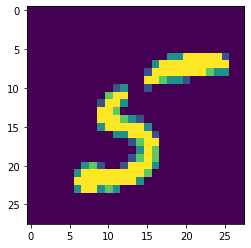

In [12]:
plt.imshow(sample)

Each sample is a $28 \times 28$ 2D-tensor representing a handwritten digit. Note that the sample can be "flattened"  into a $28 \cdot 28 = 784$ 1D-vector using the method `flatten()`.

In [13]:
sample_1d = sample.flatten()
sample_1d.shape

torch.Size([784])

A **dataloader** creates batches of samples from a dataset so that they can be passed into a model.
- Create a train and test dataloader using the following commands:
```
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
```
- Note that dataloaders are not subscriptable.
- Try to catch one batch of the dataloader and examine it.
- Write a function that reshapes a batch of size $64 \times 1 \times 28 \times 28$ into a tensor of size $784 \times 64$.<br>
(use `torch.squeeze()`, `torch.reshape()`, `torch.flatten()`, `torch.transpose()`, etc.)

In [14]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [15]:
for b in train_loader:
    break

In [16]:
b[0].shape, b[1].shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [17]:
b_reshaped = torch.squeeze(b[0])
b_reshaped = torch.flatten(b_reshaped, 1, 2)
b_reshaped = b_reshaped.transpose(0, 1)
b_reshaped.shape

torch.Size([784, 64])

In [18]:
def reshape_batch(b):
    """reshape batch of tensors"""
    b = torch.squeeze(b)
    b = torch.flatten(b, 1, 2).T
    return b

In [19]:
b_reshaped = reshape_batch(b[0])
b_reshaped.shape

torch.Size([784, 64])

- Instantiate a 4-layer MLP with the following characteristics:
    - Layer 1 (or input layer): size 784
    - Layer 2: size 128
    - Layer 3: size 128
    - Layer 4 (or output layer): size 10

In [20]:
mlp = MLP([784, 128, 128, 10])

- Pass all train samples through your network batch by batch:<br>
Create a function `process_data(dataloader, network)` that performs this.
- Gather all the outputs into 1 tensor.
- Take the argmax of the outputs to obtain the predictions.
- Get the classification report associated to your predictions and real labels:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
- What can you conclude?

In [21]:
def process_data(dataloader, network):
    """
    Pass a dataloder into a network.
    Return targets and predictions.
    """

    all_targets = []
    all_predictions = []

    for b in dataloader:

        # samples and targets
        samples = reshape_batch(b[0])
        targets = b[1]
        all_targets.extend(targets)

        # forward pass
        outputs = network.forward(samples)
        predictions = torch.argmax(outputs, dim=0)
        all_predictions.extend(predictions)
    
    return all_targets, all_predictions

In [22]:
all_targets, all_predictions = process_data(train_loader, mlp)

In [23]:
len(all_targets), len(all_predictions)

(60000, 60000)

In [24]:
all_targets[0:5], all_predictions[0:5]

([tensor(2), tensor(4), tensor(8), tensor(6), tensor(6)],
 [tensor(5), tensor(3), tensor(1), tensor(3), tensor(4)])

In [25]:
print("Train results\n")
print(classification_report(all_targets, all_predictions))

Train results

              precision    recall  f1-score   support

           0       0.11      0.15      0.12      5923
           1       0.05      0.15      0.08      6742
           2       0.11      0.03      0.04      5958
           3       0.18      0.28      0.22      6131
           4       0.03      0.03      0.03      5842
           5       0.11      0.13      0.12      5421
           6       0.07      0.02      0.04      5918
           7       0.10      0.03      0.05      6265
           8       0.10      0.09      0.09      5851
           9       0.07      0.00      0.00      5949

    accuracy                           0.09     60000
   macro avg       0.09      0.09      0.08     60000
weighted avg       0.09      0.09      0.08     60000



In [26]:
all_targets, all_predictions = process_data(test_loader, mlp)

print("Test results\n")
print(classification_report(all_targets, all_predictions))

Test results

              precision    recall  f1-score   support

           0       0.11      0.15      0.13       980
           1       0.04      0.13      0.07      1135
           2       0.13      0.03      0.05      1032
           3       0.17      0.27      0.21      1010
           4       0.02      0.02      0.02       982
           5       0.10      0.13      0.11       892
           6       0.10      0.04      0.05       958
           7       0.06      0.02      0.03      1028
           8       0.11      0.10      0.10       974
           9       0.10      0.00      0.01      1009

    accuracy                           0.09     10000
   macro avg       0.09      0.09      0.08     10000
weighted avg       0.09      0.09      0.08     10000



**Oviously, the network is untrained, and thus does not preforms better than chance (10%)!**

## Train the MLP via Ridge regression

- Update the **weights of the last layer** only so that they correspond to the solution of a **Ridge regression**.<br>
https://en.wikipedia.org/wiki/Ridge_regression<br>

More precisely:
- Pass the train set through the network and get the predictions of the penultimate layer<br>
(add a method `forward_penultimate()` in the class `MLP`)
- Compute the closed-form solution of the Ridge regression:

$$
{\displaystyle {\widehat {\beta }}_{\text{ridge}}=(X^{T}X+kI_{p})^{-1}X^{T}y}
$$

where
- $X$ is the <span style="color:blue">row-wise concatenation</span> of the penultimate outputs $\boldsymbol{a_i}^{[L-1]}$, for $i = 1, \dots, N$;
- $I_{p}$ is the identity matrix of dim $p$;
- $k > 0$ is a regularization parameter (e.g. $0.1$);
- $y$ is the <span style="color:blue">row-wise concatenation</span> of the 1-hot encoded targets $\boldsymbol{y_i}$, for $i = 1, \dots, N$ (`torch.nn.functional.one_hot()`).
- **Set weights of the last layer $\boldsymbol{W}^{[L]}$ as the solution of the Ridge regression.**
- **Set the bias of the last layer $\boldsymbol{b}^{[L]}$ to $\boldsymbol{0}$.**
- Recompute the predictions associated to the train and test sets.
- Compute the classification reports.
- What can you conclude?

In [27]:
def process_data_penultimate(dataloader, network):
    """
    Pass a dataloder into a network.
    Return targets and predictions.
    """

    all_targets = []
    all_predictions = []

    for b in dataloader:

        # samples and targets
        samples = reshape_batch(b[0])
        targets = b[1]
        all_targets.extend(targets)

        # forward pass
        outputs = network.forward_penultimate(samples)
        all_predictions.append(outputs)
    
    return all_targets, all_predictions

In [41]:
all_targets, penultimate_outputs = process_data_penultimate(train_loader, mlp)

In [42]:
len(all_targets), len(penultimate_outputs)

(60000, 938)

In [43]:
all_targets

[tensor(6),
 tensor(1),
 tensor(5),
 tensor(1),
 tensor(5),
 tensor(4),
 tensor(2),
 tensor(9),
 tensor(3),
 tensor(3),
 tensor(2),
 tensor(0),
 tensor(8),
 tensor(3),
 tensor(4),
 tensor(4),
 tensor(6),
 tensor(5),
 tensor(8),
 tensor(9),
 tensor(2),
 tensor(5),
 tensor(8),
 tensor(7),
 tensor(7),
 tensor(0),
 tensor(6),
 tensor(0),
 tensor(1),
 tensor(7),
 tensor(1),
 tensor(8),
 tensor(4),
 tensor(5),
 tensor(4),
 tensor(2),
 tensor(9),
 tensor(1),
 tensor(9),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(9),
 tensor(7),
 tensor(3),
 tensor(2),
 tensor(3),
 tensor(9),
 tensor(1),
 tensor(7),
 tensor(2),
 tensor(1),
 tensor(9),
 tensor(4),
 tensor(2),
 tensor(6),
 tensor(1),
 tensor(3),
 tensor(9),
 tensor(7),
 tensor(6),
 tensor(4),
 tensor(5),
 tensor(7),
 tensor(1),
 tensor(8),
 tensor(4),
 tensor(1),
 tensor(9),
 tensor(5),
 tensor(0),
 tensor(5),
 tensor(9),
 tensor(7),
 tensor(7),
 tensor(4),
 tensor(2),
 tensor(6),
 tensor(6),
 tensor(1),
 tensor(7),
 tensor(0),
 tensor(8),
 ten

In [44]:
penultimate_outputs[0].shape

torch.Size([128, 64])

In [47]:
def Ridge_solution(X, y, k):
    
    targets = torch.tensor(y)
    targets = torch.nn.functional.one_hot(targets, num_classes=10)
    targets = targets.float()
    
    outputs = torch.cat(X, dim=1)
    outputs = outputs.T
    
    X_tmp = torch.mm(outputs.T, outputs) + k * torch.eye(outputs.shape[1])
    X_tmp = torch.mm(torch.pinverse(X_tmp), outputs.T)
    beta = torch.mm(X_tmp, targets)
    
    return beta

In [56]:
beta = Ridge_solution(penultimate_outputs, all_targets, k=0.1)

In [57]:
beta.shape

torch.Size([128, 10])

In [58]:
last_weights = beta.T

In [59]:
mlp.weights[-1] = last_weights
mlp.biases[-1] = torch.zeros(10, 1)

In [60]:
train_targets, train_predictions = process_data(train_loader, mlp)

In [61]:
len(train_targets)

60000

In [62]:
len(train_predictions)

60000

In [63]:
print("Train results\n")
print(classification_report(train_targets, train_predictions))

Train results

              precision    recall  f1-score   support

           0       0.06      0.04      0.05      5923
           1       0.08      0.15      0.10      6742
           2       0.17      0.30      0.22      5958
           3       0.14      0.11      0.12      6131
           4       0.11      0.04      0.06      5842
           5       0.06      0.04      0.05      5421
           6       0.11      0.09      0.10      5918
           7       0.14      0.24      0.18      6265
           8       0.02      0.01      0.01      5851
           9       0.11      0.09      0.10      5949

    accuracy                           0.11     60000
   macro avg       0.10      0.11      0.10     60000
weighted avg       0.10      0.11      0.10     60000



**The results have drastically improved!**
- Note that $\boldsymbol{W}^{[1]}, \boldsymbol{W}^{[2]}$ are kept untrained (randomly initialized).
- Only $\boldsymbol{W}^{[3]}$ is trained via by a **Ridge regression**.
- This suffices to drastically improve the results!